```
.inter
(g, j, s)
g.info <- .udoc
j.info <- .idoc

g.strRep -> C 
            o          M
            n --BGE--> L ---> out
            c --BGE--> P ---> put
            a          s
j.strRep -> t
```

In [3]:
%time
bge_path = "/media/wuyuhuan/bge-small-zh"
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm_

import logging

import time
import random
from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
logging.info(f"Usable GPU: {torch.cuda.device_count()}")  
tokenizer = AutoTokenizer.from_pretrained(bge_path)

def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

same_seed(42)

class BGE_FTDataset(Dataset):
    def __init__(self, mode: str, in_file: str, tokenizer: AutoTokenizer, ratio: float = 1.0):
        """
        mode: str, one of ['train', 'valid', 'test']
        in_file: str, path to the input csv file.
        tokenizer: AutoTokenizer, tokenizer for the model.
        ratio: float, the ratio of the data to be used. Default: 1.0. 
            set to 0.01 for functionality testing.
        """
        self.mode = mode
        self.dataset = pd.read_csv(in_file).sample(frac=ratio)
        self.tokenizer = AutoTokenizer.from_pretrained(bge_path)
        logging.info(f"Dataset {mode} Loaded. Shape: {self.dataset.shape}")
        self.data = []
        self.tokenize_data() # -> self.data will look like: [(user_id, job_id, tokenized_cv, tokenized_jd, label), ...] 


    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, idx):
        return {
            "user_id": self.data[idx][0],
            "job_id": self.data[idx][1],
            "model_input": {
                "model_input_cv": self.data[idx][2],
                "model_input_jd": self.data[idx][3],
                "label": self.data[idx][4],
            }
        }
        
    def tokenize_data(self):
        """
        Tokenize the data in the dataset. Modify the dataset in place to 
        reduce memory costs.
        """
        for idx, row in self.dataset.iterrows():
            cv = row['cv'] 
            jd = row['jd']
            # TODO: More on Modifying the Tokenizing methods.
            tokenized_cv = self.tokenizer(cv, return_tensors='pt', padding='max_length', truncation=True, max_length=512) # (input_ids, attention_mask, token_type_ids): (bs, seq_len)
            tokenized_jd = self.tokenizer(jd, return_tensors='pt', padding='max_length', truncation=True, max_length=512) # (input_ids, attention_mask, token_type_ids): (bs, seq_len)
            self.data.append((row['user_id:token'], row['job_id:token'], tokenized_cv, tokenized_jd, torch.tensor(row['browsed:label'], dtype=torch.float32)))
        return 
        
train_dataset = BGE_FTDataset('train', 'dataset/processed_train.csv', tokenizer,ratio=0.001)
valid_dataset = BGE_FTDataset('valid', "dataset/processed_valid.csv", tokenizer,ratio=0.001)
test_dataset = BGE_FTDataset('test', "dataset/processed_test.csv", tokenizer, ratio=0.05)

# train_dataset[0]
# valid_dataset[0]
# test_dataset[0]

2025-01-02 22:05:43,967 - INFO - Usable GPU: 10


CPU times: user 0 ns, sys: 12 μs, total: 12 μs
Wall time: 226 μs


2025-01-02 22:06:23,397 - INFO - Dataset train Loaded. Shape: (512, 7)
2025-01-02 22:07:54,384 - INFO - Dataset valid Loaded. Shape: (64, 7)
2025-01-02 22:08:01,595 - INFO - Dataset test Loaded. Shape: (3197, 7)


In [13]:
from typing import List
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, log_loss
class Evaluator:
    """
    Evaluator for the BGE-FT model.
    """
    def __init__(self):
        #TODO: the label values are currently only assumed to be binary
        # For further experiments, we need to make the label values more general.  
        self.uid2topk = {} # {uid: [(score, label), ...]}  
        
        self.topk = 10
        self.metric2func = {
            "ndcg": self._ndcg,
            "precision": self._precision,
            "recall": self._recall,
            "map": self._map,
            "mrr": self._mrr,
            "auc": self._auc,
            "logloss": self._logloss,
        }
        self.cls_metrics = ["auc", "logloss"]
        self.rkg_metrics = ["ndcg", "precision", "recall", "map", "mrr"]
        

    def collect(self, uid, score, label):
        """
        Process a batch of data. Save the data to the evaluator. 
        Input params are lists of same length as batch size.
        After this func, uid2topk will look like: {uid: [(score, label), ...]}
        where each uid has interaction list sorted by score

        Args:
            uid: list, list of user ids.  
            score: list, list of scores.
            label: list, list of labels.
            
        Returns:
            None
        """
        for u, s, l in zip(uid, score, label):
            if u not in self.uid2topk:
                self.uid2topk[u] = []
            self.uid2topk[u].append((s, l)) 

        for u in self.uid2topk:
            self.uid2topk[u] = sorted(self.uid2topk[u], key=lambda x: x[0], reverse=True)
         
    def evaluate(self, K: List[int]):
        """
        Evaluate the model using the collected data and the pass value k.
        Args:
            K: List[int], a list of k values for ranking metrics.
        
        return:
            result: dict, a dictionary of evaluation results.
            result_str: str, a formatted string of the evaluation results.
        """
        result = {} # {cls_m1: value1, cls_m2: value2, ..., rkg_m1@k1: value1, rkg_m2@k2: value2, ...}

        # Calculate the metrics
        for cls_metric in self.cls_metrics:
            matric_val = self.metric2func[cls_metric]()
            result[cls_metric] = matric_val

        for rkg_metric in self.rkg_metrics:
            for k in K:
                result[rkg_metric + '@' + str(k)] = self.metric2func[rkg_metric](k)
        
        result_str = self._format_str(result)
        return result, result_str
    

    # below are the ranking metric functions. With most of are indirect copy from the recbole.metrics.
    def _ndcg(self, k):
        base = []
        idcg = []

        # save base and idcg(Ideal DCG) for each position
        for i in range(k):
            base.append(np.log(2) / np.log(i + 2)) # np.log(2) / np.log(i + 2) = log_{i + 2}(2)
            if i > 0:
                idcg.append(base[i] + idcg[i - 1])
            else:
                idcg.append(base[i])

        # calculate the dcg
        tot = 0
        for uid in self.uid2topk:
            dcg = 0
            pos = 0
            for i, (score, label) in enumerate(self.uid2topk[uid][:k]):
                dcg += (2 ** label - 1) * base[i] # 2^rel - 1 / log_(2)(i + 1)
                pos += label # TODO: If label is not binary, this should be modified.
            tot += dcg / idcg[int(pos) - 1]
        return tot / len(self.uid2topk)

    def _precision(self, k):
        tot = 0
        valid_length = 0
        for uid in self.uid2topk:
            rec = 0
            rel = 0
            for i, (score, label) in enumerate(self.uid2topk[uid][:k]):
                rec += 1
                rel += label # TODO: If label is not binary, this should (maybe) be modified.
            try:
                tot += rel / rec
                valid_length += 1
            except:
                continue
        return tot / valid_length
    
    def _recall(self, k):
        tot = 0
        valid_length = 0
        for uid in self.uid2topk:
            rec = 0
            rel = 0
            for i, (score, label) in enumerate(self.uid2topk[uid]):
                if i < k:
                    rec += label
                rel += label #TODO: If label is not binary, this should (maybe) be modified.
            try:
                tot += rec / rel
                valid_length += 1
            except:
                continue
        return tot / valid_length

    # TODO: The MAP and MRR functions are not understood yet.
    def _map(self,k):
        tot = 0
        for uid in self.uid2topk:
            tp = 0
            pos = 0
            ap = 0
            for i, (score, label) in enumerate(self.uid2topk[uid][:k]):
                if label == 1:
                    tp += 1
                    pos += 1
                    ap += tp / (i + 1)
            if pos > 0:
                tot += ap / pos
        return tot / len(self.uid2topk)

    def _mrr(self, k):
        tot = 0
        for uid in self.uid2topk:
            for i, (score, label) in enumerate(self.uid2topk[uid]):
                if label == 1:
                    tot += 1 / (i + 1)
                    break
        return tot / len(self.uid2topk)
        
    
    # below are the classification metric functions
    def _auc(self):
        """
        Calculate the AUC score.
        """
        total_auc = 0
        valid_auc_num = 0
        for uid, topk in self.uid2topk.items():
            score, labels = zip(*topk)
            try:
                auc = roc_auc_score(labels, score)
                total_auc += auc
                valid_auc_num += 1
            except:
                continue
        return total_auc / valid_auc_num
        

    def _logloss(self):
        """
        Calculate the logloss.
        """
        total_logloss = 0
        valid_logloss_num = 0
        for uid, topk in self.uid2topk.items():
            score, labels = zip(*topk)
            try:
                logloss = log_loss(labels, score)
                valid_logloss_num += 1
                total_logloss += logloss
            except:
                continue
        return total_logloss / valid_logloss_num

    # other utility functions for evaluator
    def _format_str(self, result):
        res = ''
        for metric in result.keys():
            res += '\n\t{}:\t{:.4f}'.format(metric, result[metric])
        return res

In [16]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False,num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False,num_workers=0)

class BGE_FTModel(torch.nn.Module):
    def __init__(self, rag_model):
        super(BGE_FTModel, self).__init__()
        logging.info(f"Initializing Model Based on path: {rag_model}")
        self.jd_retriever = AutoModel.from_pretrained(rag_model).to(device)
        self.cv_retriever = AutoModel.from_pretrained(rag_model).to(device)
        self.predictor = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        ).to(device)

        self.loss_fn = nn.BCELoss()
        # xavier initialization for predictor
        for m in self.predictor:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        
        logging.info(f"Frozing Parameters...")
        self.frozen_target_parameters()
        logging.info(f"Model Initialized.")
        self.print_trainable_parameters()


    def forward(self, sample):
        """sample: dict like {
            "model_input_jd": {"input_ids": tensor, "attention_mask": tensor, "token_type_ids": tensor},
            "model_input_cv": {"input_ids": tensor, "attention_mask": tensor, "token_type_ids": tensor}
            "label": tensor
        }
        """
        jd = {k: v.squeeze(1) for k, v in sample["model_input_jd"].items()}
        # (input_ids: tensor(bs, seq_len), attention_mask: tensor(bs, seq_len), token_type_ids: tensor(bs, seq_len))
        cv = {k: v.squeeze(1) for k, v in sample["model_input_cv"].items()}
        jd_output = self.jd_retriever(**jd)[0][:, 0]
        cv_output = self.cv_retriever(**cv)[0][:, 0] # (bs, seq_len)
        # concat jd and cv
        concat_output = torch.cat((jd_output, cv_output), 1)
        return self.predictor(concat_output)
    
    def calculate_loss(self, output, label):
        #TODO: Apply more innovative loss functions.
        return self.loss_fn(output, label)

    def frozen_target_parameters(self):
        for param in self.jd_retriever.parameters():
            param.requires_grad = False
        for param in self.cv_retriever.parameters():
            param.requires_grad = False
    
    def print_trainable_parameters(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        logging.info(f"Trainable Params: {trainable_params}. Total Params: {total_params}. Trainable Paramaters Ratio: {trainable_params/total_params}")

class Trainer(object):
    def __init__(self, model, train_dataloader, valid_dataloader, test_dataloader, optimizer, eval_step, verbose=True):
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.test_dataloader = test_dataloader
        self.clip_grad_norm = None
        self.optimizer = optimizer
        self.eval_step = 1

        self.verbose = verbose

    def train(self, epochs, early_stopping_epochs=5):
        train_loss = valid_loss = float('inf')
        
        # the below init values are for early stopping
        best_valid = cur_best_valid = float('inf')
        cur_step_from_best_val = 0
        
        for epoch_idx in range(epochs):
            # train
            train_loss = self._train_epoch(epoch_idx, self.train_dataloader) # mean loss of this epoch

            # valid
            valid_loss = self._valid_epoch()
            if self.verbose:
                logging.info(f"Epoch {epoch_idx} Train mean Loss: {train_loss:.4f}, Valid mean Loss: {valid_loss:.4f}")
                
            # early stopping
            if (epoch_idx + 1) % self.eval_step == 0:
                if self.verbose:
                    logging.info(f"Epoch {epoch_idx} starts early stopping check.")
                cur_best_valid, cur_step_from_best_val, stop_flag, update_flag = self._early_stopping(
                    valid_loss, cur_best_valid, cur_step_from_best_val, early_stopping_epochs)
                
                if update_flag:
                    best_valid = cur_best_valid
            
                if stop_flag:
                    if self.verbose:
                        logging.info(f"Early stopping at epoch {epoch_idx}")
                    break
        
        return best_valid

    @torch.no_grad()
    def _valid_epoch(self):
        """valid the model with valid data by calculate the loss
        """
        loss_items = []
        # set model to eval mode
        self.model.eval()
        
        # calculate loss on validation set
        for batch in self.valid_dataloader:
            batch = {k: v.to(device) for k, v in batch["model_input"].items()} # batch: {"model_input_jd", "model_input_cv": dict, "label": tensor}
            label = batch["label"].unsqueeze(1) # (bs, 1)
            output = self.model(batch) # (bs, 1)
            loss_items.append(self.model.calculate_loss(output, label).item())
        valid_loss = np.mean(loss_items)

        return valid_loss
    
    @torch.no_grad()
    def eval(self, evaluator):
        """
        Using the test dataloader to evaluate the model.
        For each (cv, jd) pair, we predict the probability of the cv being browsed.
        The evaluation results are saved to the save_path as the following format:

        The evaluation matriceare all based on top-k selection. for each cv_i, the 
        top-k are selected from all (cv_i, jd) pairs that appear in the test set. 
        After consideration, due to the context of precise-recommendation matching 
        task, we decide if jd_j are in the testset records but not being recorded 
        with cv_i in the testset, we will not consider jd_j in the top-k selection
        for cv_i.
        
        params:
            evaluator: Evaluator, the evaluator for the model.

        return:
            result: list
        """
        # set model to eval mode
        self.model.eval()

        # predicting scores, while saving the predictions records.
        for batch in tqdm(self.test_dataloader):
            uid = batch["user_id"] # List of length bs
            batch_inputs = {k: v.to(device) for k, v in batch["model_input"].items()} # batch: {"model_input_jd", "model_input_cv": dict, "label": tensor}
            scores = self.model(batch_inputs).squeeze(-1).cpu().tolist()
            labels = batch_inputs["label"].squeeze(-1).cpu().tolist()
            evaluator.collect(uid, scores, labels)

        # evaluate the results
        results, results_str = evaluator.evaluate([1])
        return results, results_str

    # below is indirect copy from https://github.com/hyp1231/SHPJF/tree/master/model
    def _train_epoch(self, epoch_idx: int, train_dataloader: DataLoader):
        """Train the model in an epoch

        Args:
            epoch_idx (int): The current epoch id.
            train_data (DataLoader): The train data.

        Returns:
            float/tuple: The sum of loss returned by all batches in this epoch. If the loss in each batch contains
            multiple parts and the model return these multiple parts loss instead of the sum of loss, it will return a
            tuple which includes the sum of loss in each part.
        """
        self.model.train()
        total_loss = 0
        iter_data = (
            tqdm(
                enumerate(train_dataloader),
                total = len(train_dataloader),
                desc=f"Train Epoch {epoch_idx:>5}",
            )
        )

        for step, batch in iter_data: # batch: {"user_id": tensor, "job_id": tensor, "model_input": dict}
            batch = {k: v.to(device) for k, v in batch["model_input"].items()} # batch: {"model_input_jd", "model_input_cv": dict, "label": tensor}
            label = batch["label"].unsqueeze(1).to(device) # (bs, 1)
            self.optimizer.zero_grad()
            output = self.model(batch) # tensor(bs, 1)
            loss = self.model.calculate_loss(output, label) # output: (bs, 1), label: (bs, 1)
            total_loss += loss.item()
            self._check_nan(loss)
            loss.backward()
            if self.clip_grad_norm:
                clip_grad_norm_(self.model.parameters(), **self.clip_grad_norm)
            self.optimizer.step()
    
        return total_loss / len(train_dataloader)
    
    def _early_stopping(self, value, best, cur_step, max_step):
        """validation-based early stopping

        Args:
            value (float): current result
            best (float): best result
            cur_step (int): the number of consecutive steps that did not exceed the best result
            max_step (int): threshold steps for stopping

        Returns:
            tuple:
            - best: float,
            best result after this step
            - cur_step: int,
            the number of consecutive steps that did not exceed the best result after this step
            - stop_flag: bool,
            whether to stop
            - update_flag: bool,
            whether to update
        """
        stop_flag = False
        update_flag = False
        if value > best:
            cur_step = 0
            best = value
            update_flag = True
        else:
            cur_step += 1
            if cur_step > max_step:
                stop_flag = True
        return best, cur_step, stop_flag, update_flag

    def _check_nan(self, loss):
        if torch.isnan(loss).any():
            raise ValueError("Model diverged with loss = NaN")
        return

    
model = BGE_FTModel(bge_path).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()
trainer = Trainer(model, train_loader, valid_loader, test_loader, optimizer, eval_step=1)
best_valid = trainer.train(1)
evaluator = Evaluator()
result, result_str = trainer.eval(evaluator)

2025-01-02 22:30:37,706 - INFO - Initializing Model Based on path: /media/wuyuhuan/bge-small-zh
2025-01-02 22:30:39,087 - INFO - Frozing Parameters...
2025-01-02 22:30:39,093 - INFO - Model Initialized.
2025-01-02 22:30:39,107 - INFO - Trainable Params: 266529. Total Params: 48174369. Trainable Paramaters Ratio: 0.005532589331891405
Train Epoch     0: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
2025-01-02 22:30:40,533 - INFO - Epoch 0 Train mean Loss: 0.5456, Valid mean Loss: 0.5239
2025-01-02 22:30:40,534 - INFO - Epoch 0 starts early stopping check.
100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


In [17]:
result

{'auc': 0.4744354838709677,
 'logloss': 0.7711833453459979,
 'ndcg@1': 0.20428422152560083,
 'precision@1': 0.20428422152560083,
 'recall@1': 0.6349275362318841,
 'map@1': 0.20428422152560083,
 'mrr@1': 0.2468440563268149}

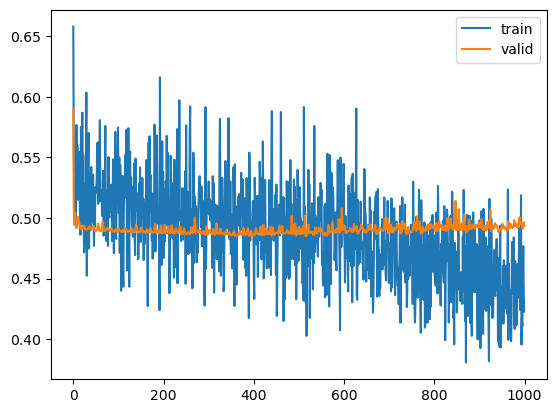

In [10]:
train_losses

valid_losses

def plot_train_valid_losses(train_losses, valid_losses):
    import matplotlib.pyplot as plt
    """

    """
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend()
    plt.show()
plot_train_valid_losses(train_losses, valid_losses)

In [15]:
print(model)

BGE_FTModel(
  (jd_retriever): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

jd will look like this after decoding: 

[CLS] 岗 位 职 责 ： 负 责 公 司 各 类 图 书 的 选 题 、 组 稿 、 编 辑 、 审 读 工 作 。 任 职 要 求 ： 1 、 正 规 院 校 一 类 本 科 及 以 上 学 历 ， 英 语 及 相 关 专 业 毕 业 ， 有 专 业 八 级 证 书 ； 2 、 综 合 素 质 佳 ， 表 达 流 畅 ； 3 、 有 较 强 的 责 任 心 及 较 好 的 抗 压 能 力 ； 4 、 心 态 好 ， 繁 忙 工 作 中 依 然 能 尽 职 尽 责 的 完 成 自 己 的 工 作 任 务 ； 5 、 有 初 、 高 中 家 教 工 作 经 验 或 教 师 工 作 经 验 者 尤 佳 ； 6 、 我 们 需 要 的 是 热 爱 教 育 及 出 版 行 业 的 有 志 之 士 ， 认 真 踏 实 ， 求 真 务 实 ， 与 天 星 共 荣 辱 ， 同 创 辉 煌 ！ 福 利 待 遇 ： 1. 六 险 一 金 齐 全 （ 养 老 、 医 疗 、 失 业 、 工 伤 、 生 育 、 住 房 公 积 金 ） ； 2. 五 天 工 作 制 ， 享 受 国 家 法 定 节 假 日 及 各 项 过 节 福 利 ； 3. 丰 厚 的 季 度 奖 和 年 终 奖 ， 并 为 员 工 提 供 每 年 健 康 体 检 ； 4. 带 薪 假 期 （ 年 假 、 婚 假 、 病 假 、 产 假 等 ） ； 5. 每 年 为 员 工 订 阅 上 万 本 各 类 期 刊 杂 志 和 图 书 ， 提 供 再 教 育 补 贴 ； 6. 旅 游 ， 聚 餐 及 各 类 综 艺 活 动 ； 7. 提 供 各 个 岗 位 的 内 部 及 外 派 带 薪 培 训 。 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

cv will look like this after decoding: 

[CLS] 个 人 简 历 : 期 望 行 业 : 教 育 / 培 训 / 院 校, 贸 易 / 进 出 口, 旅 游 / 度 假 教 育 / 培 训, 旅 游 / 度 假 / 出 入 境 服 务, 贸 易 跟 单 当 前 行 业 : 旅 游 / 度 假 旅 游 / 度 假 / 出 入 境 服 务 工 作 经 历 : 互 联 网 参 考 模 型 osi 七 层 | 外 国 语 言 文 学 | 预 定 | 员 工 | 处 理 | 英 语 教 育 | office | 英 语 | 财 务 部 门 | 商 务 | 酒 店 | 订 票 | 邮 件 | 协 调 | 图 书 | 操 作 | 线 上 | 出 票 | 网 站 | 接 听 | 外 国 | 财 务 | 行 程 | 咨 询 | 协 助 | 企 业 | 编 辑 | 团 队 领 导 | 服 务 | 工 具 | 学 习 能 力 | 出 差 | 英 语 读 写 | 维 护 | 通 讯 | 电 话 | 系 统 | 业 务 | 沟 通 能 力 | 国 际 机 票 操 作 | 客 户 | 规 划 | 机 票 | 订 单 | 国 际 | 大 客 户 | 团 队 | 软 件 | 适 应 能 力 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]